# Welcome to the Synergy Roundtable
created by Stephan Koch
do not hesitate to contact me: stephan.koch@hpe.com


Nutzung von Ansible für die Konfiguration von Synergy über OneView
Dabei werden verschiedene Beispiele an playbooks aufgezeigt die die Objekte in OneView definieren, abfragen oder updaten

Vorraussetzung:
auf dem Host sind ansible, python3, hponeview-python installiert
in meinem Fall nutze ich ein docker container um eine passende ansible Umgebung bereitzustellen
Anleitung dazu hier: https://github.com/dderichswei/synergy

Dokumentation und Repos auf https://github.com/HewlettPackard

## Install hponeview 5.0 python Library

In [62]:
#pip3 install --user  --proxy http://16.46.41.14:8080 /home/notebook/notebooks/ov5/
pip3 search hpOneView  



hpOneView (5.1.1)  - HPE OneView Python Library
  INSTALLED: 5.0.0
  LATEST:    5.1.1


## Install hpeoneview Ansible module

In [ ]:
$ git clone https://github.com/HewlettPackard/oneview-ansible.git
pip install -r requirements.txt

###    check ansible-playbook version

In [8]:
ansible-playbook --version

ansible-playbook 2.9.4
  config file = /home/notebook/notebooks/ansible.cfg
  configured module search path = ['/home/notebook/hponeview/oneview-ansible/library']
  ansible python module location = /usr/local/lib/python3.7/site-packages/ansible
  executable location = /usr/local/bin/ansible-playbook
  python version = 3.7.5 (default, Oct 17 2019, 12:21:00) [GCC 8.3.1 20190223 (Red Hat 8.3.1-2)]


In [ ]:
cat hosts

In [ ]:
cat oneview_config.json   ##Anmeldedaten

In [ ]:
{
  "ip": "10.0.20.50",
  "credentials": {
    "userName": "python",
    "authLoginDomain": "local",
    "password": "<PW>"
  },
  "image_streamer_ip": "10.0.20.54",
  "api_version": 800
}

## Lese ein Server Profile aus

# cat oneview_gatherSP.yml


In [57]:
cat << 'EOF' > oneview_gatherSP.yml
- hosts: ovctc
  vars:
    - config: "{{ playbook_dir }}/oneview_config.json"

  tasks:
    - name: Gather facts about a Server Profile by name
      oneview_server_profile_facts:
        config: "{{ config }}"
        name: "10.1.36.101-Container-ESX1"
      delegate_to: localhost

    - debug: var=server_profiles
    - debug: var=server_profiles[0].serialNumber
    - debug: msg="{{server_profiles | map(attribute='eTag') | list }}"
EOF

In [58]:
ansible-playbook -i hosts oneview_gatherSP.yml


PLAY [ovctc] *******************************************************************

TASK [Gather facts about a Server Profile by name] *****************************
ok: [10.0.20.50 -> localhost]

TASK [debug] *******************************************************************
ok: [10.0.20.50] => {
    "server_profiles": [
        {
            "affinity": "Bay",
            "associatedServer": null,
            "bios": {
                "manageBios": false,
                "overriddenSettings": [],
                "reapplyState": "NotApplying"
            },
            "boot": {
                "manageBoot": true,
                "order": [
                    "SD"
                ]
            },
            "bootMode": {
                "manageMode": true,
                "mode": "UEFIOptimized",
                "pxeBootPolicy": "Auto",
                "secureBoot": "Unmanaged"
            },
            "category": "server-profiles",
            "connectionSettings": {
             

## Lege einen User an 

In [60]:
cat << 'EOF' > create_user.yml 
###
#  create user
###
---
- hosts: ovctc
  vars:
    - config: "{{ playbook_dir }}/oneview_config.json"
      user_name: nobody
      email: nobody@hpe.com

  tasks:
    - name: Gather facts about user
      oneview_user_facts:
        config: "{{ config }}"
      delegate_to: localhost

    - debug: var=users


    - name: Create a User
      oneview_user:
        config: "{{ config }}"
        state: present
        data:
          userName: "{{ user_name }}"
          password: Password
          emailAddress: "{{ email }}"
          enabled: true
          fullName: Mr Nobody
          mobilePhone: '+49 170 12345'
          type: 'UserAndPermissions'
          officePhone: '+49 170 12345'
          permissions:
             - roleName: 'Infrastructure administrator'
      delegate_to: localhost
      register: user_1


EOF

ansible-playbook -i hosts create_user.yml


PLAY [ovctc] *******************************************************************

TASK [Gather facts about user] *************************************************
ok: [10.0.20.50 -> localhost]

TASK [debug] *******************************************************************
ok: [10.0.20.50] => {
    "users": [
        {
            "category": "users",
            "created": null,
            "description": null,
            "eTag": null,
            "emailAddress": "",
            "enabled": true,
            "fullName": "Default appliance administrator",
            "mobilePhone": "",
            "modified": null,
            "name": null,
            "officePhone": "",
            "permissions": [
                {
                    "roleName": "Infrastructure administrator",
                    "scopeUri": null
                }
            ],
            "state": null,
            "status": null,
            "type": "UserAndPermissions",
            "uri": "/rest/users/administ

## Erzeuge Netzwerkdefinitionen

In [ ]:
cat <<'EOF' > oneview_ethernet.yml
###
---
- hosts: ovctc
  vars:
    config: "{{ playbook_dir }}/oneview_config.json"
    network_name: 'OneViewSDK Test Ethernet Network'
  tasks:
    - name: Create an Ethernet Network
      oneview_ethernet_network:
        config: "{{ config }}"
        state: present
        data:
          name: '{{ network_name }}'
          vlanId: 200
          ethernetNetworkType: Tagged
          purpose: General
          smartLink: false
          privateNetwork: false
          bandwidth:
              maximumBandwidth: 2000
              typicalBandwidth: 1000
      delegate_to: localhost

    - name: Update the Ethernet Network changing bandwidth and purpose
      oneview_ethernet_network:
        config: "{{ config }}"
        state: present
        data:
          name: '{{ network_name }}'
          purpose: Management
          bandwidth:
              maximumBandwidth: 3000
              typicalBandwidth: 2000
      delegate_to: localhost

    - name: Reset to the default network connection template
      oneview_ethernet_network:
        config: "{{ config }}"
        state: default_bandwidth_reset
        data:
          name: '{{ network_name }}'
      delegate_to: localhost

    - name: Create Ethernet Networks in bulk
      oneview_ethernet_network:
        config: "{{ config }}"
        state: present
        data:
          vlanIdRange: '1-3,5,7'
          purpose: General
          namePrefix: AnsibleTestNetwork
          smartLink: false
          privateNetwork: false
          bandwidth:
              maximumBandwidth: 10000
              typicalBandwidth: 2000
      delegate_to: localhost
    - debug: msg="{{ethernet_network_bulk | map(attribute='name') | list }}"
EOF
ansible-playbook -i hosts oneview_ethernet.yml

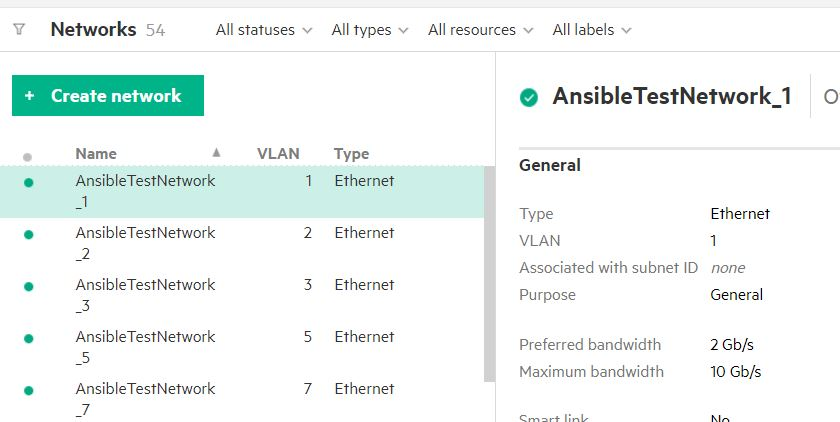

## Welche Alerts sind OneView vorhanden ?

In [13]:
cat << 'EOF'  >oneview_alert.yml
###
---
- hosts: all
  vars:
    - config: "{{ playbook_dir }}/oneview_config.json"
  tasks:
    - name: Gather facts about the last 2 alerts
      oneview_alert_facts:
        config: "{{ config }}"
        params:
          count: 2
      delegate_to: localhost

    - debug: var=alerts

    - name: Gather facts about the alerts with state 'Cleared'
      oneview_alert_facts:
        config: "{{ config }}"
        params:
          count: 2
          filter: "alertState='Cleared'"
      delegate_to: localhost

    - debug: var=alerts

    - name: Gather facts about the alerts with urgency 'High'
      oneview_alert_facts:
        config: "{{ config }}"
        params:
          count: 5
          filter: "urgency='High'"
      delegate_to: localhost

    - debug: var=alerts
EOF
ansible-playbook -i hosts oneview_alert.yml


PLAY [all] *********************************************************************

TASK [Gather facts about the last 2 alerts] ************************************
ok: [10.0.20.50 -> localhost]

TASK [debug] *******************************************************************
ok: [10.0.20.50] => {
    "alerts": [
        {
            "activityUri": null,
            "alertState": "Cleared",
            "alertTypeID": "server-hardware.mp.fw.server.firmwareinventory",
            "assignedToUser": null,
            "associatedEventUris": [
                "/rest/events/2541432"
            ],
            "associatedResource": {
                "associationType": "HAS_A",
                "resourceCategory": "server-hardware",
                "resourceName": "CTC H5 HE11, bay 2",
                "resourceUri": "/rest/server-hardware/39313738-3034-5A43-4A39-333930363157"
            },
            "category": "alerts",
            "changeLog": [
                {
                    "create

## Ein Server Profile from Scratch anzulegen

In [35]:
cat << 'EOF' >oneview_newSP.yml

- hosts: all
  vars:
    - config: "{{ playbook_dir }}/oneview_config.json"

  tasks:
    - name: Create server profile SP-scratch
      oneview_server_profile:
         config: "{{ config }}"
         state: present
         auto_assign_server_hardware: False
         data:
             name:                       "SP-created by Ansible"
             description:                "Assigned by Stephan"
             affinity:                   "BayAndServer"
             enclosureGroupName:         "3 Frame VC-ETH SAS-Switch"
             serverHardwareTypeName:     "SY480G10 M1:416SA M3:4820CNA"
             hideUnusedFlexNics:         true
             bios:
                 manageBios:     true
                 overriddenSettings:
                     - id:    "NumaGroupSizeOpt"
                       value: "Clustered"
                     - id:    "PowerRegulator"
                       value: "OsControl"
                     - id:    "WorkloadProfile"
                       value: "Virtualization-PowerEfficient"
             firmware:
                 manageFirmware:            true
                 forceInstallFirmware:      false
                 firmwareInstallType:       "FirmwareAndOSDrivers"
                 firmwareBaselineName:      "HPE Synergy Custom SPP 201909 2019 09 26"
             connectionSettings:
               connections:
                     - id: 1
                       portId: "Mezz 3:1-a"
                       name: "Prod-A"
                       functionType: "Ethernet"
                       networkName: "Management 0020"
                       requestedMbps: 4000
                       requestedVFs: 4
                     - id: 2
                       portId: "Mezz 3:2-a"
                       name: "Prod-B"
                       functionType: "Ethernet"
                       networkName: "Management 0020"
                       requestedMbps: 4000
                       requestedVFs: 4
                     - id: 3
                       portId: "Auto"
                       name: "Fabric-A"
                       functionType: "FibreChannel"
                       networkName: "FCoE Fabric A"
                       requestedMbps: 4000
                     - id: 4
                       portId: "Auto"
                       name: "Fabric-B"
                       functionType: "FibreChannel"
                       networkName: "FCoE Fabric B"
                       requestedMbps: 4000
             sanStorage:
                hostOSType: "RHE Linux (5.x, 6.x, 7.x)"
                manageSanStorage: true
                volumeAttachments:
                - id: 1
                  lunType: "Manual"
                  lun: "10"
                  volumeStorageSystemName: "3PAR8200"
                  volume:
                    properties:
                      name: "DemoVolume_by_ansible 001-01"
                      storagePoolName: "FC_r5"
                      provisioningType: "Thin"
                      size: 268435456
                      isShareable: false
                    isPermanent: false
                  storagePaths:
                  - connectionId: 3
                    isEnabled: true
                    targetSelector: "Auto"
                  - connectionId: 4
                    isEnabled: true
                    targetSelector: "Auto"

      delegate_to: localhost
      
    - debug: var=server_hardware
EOF
ansible-playbook -i hosts oneview_newSP.yml


PLAY [all] *********************************************************************

TASK [Create server profile SP-scratch] ****************************************
changed: [10.0.20.50 -> localhost]

TASK [debug] *******************************************************************
ok: [10.0.20.50] => {
    "server_hardware": null
}

PLAY RECAP *********************************************************************
10.0.20.50                 : ok=2    changed=1    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   



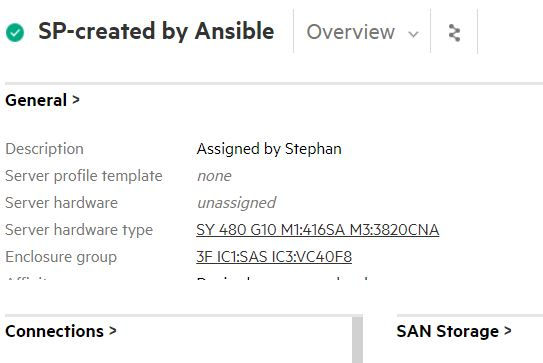

## Erzeuge ein neues Server Profile anhand den Werten eines vorhanden:


In [48]:
cat << 'EOF' >oneview_gather_and_createSP.yml
- hosts: all
  vars:
    - config: "{{ playbook_dir }}/oneview_config.json"

  tasks:
    - name: Gather facts about a Server Profile by name
      oneview_server_profile_facts:
        config: "{{ config }}"
        name: "SP-created by Ansible"
      delegate_to: localhost

#    - debug: var=server_profiles
    - debug: var=server_profiles[0].serialNumber
    - debug: msg="{{server_profiles | map(attribute='eTag') | list }}"
    - copy: content={{ server_profiles | to_nice_yaml }} dest="{{ playbook_dir }}/out.yml"
      delegate_to: localhost


EOF
ansible-playbook -i hosts oneview_gather_and_createSP.yml


PLAY [all] *********************************************************************

TASK [Gather facts about a Server Profile by name] *****************************
ok: [10.0.20.50 -> localhost]

TASK [debug] *******************************************************************
ok: [10.0.20.50] => {
    "server_profiles[0].serialNumber": "VCG6LQ80CF"
}

TASK [debug] *******************************************************************
ok: [10.0.20.50] => {
    "msg": [
        "1589782942004/3"
    ]
}

TASK [copy] ********************************************************************
changed: [10.0.20.50 -> localhost]

PLAY RECAP *********************************************************************
10.0.20.50                 : ok=4    changed=1    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   



In [49]:
cat out.yml

-   affinity: BayAndServer
    associatedServer: null
    bios:
        manageBios: true
        overriddenSettings:
        -   id: WorkloadProfile
            value: Virtualization-PowerEfficient
        -   id: NumaGroupSizeOpt
            value: Clustered
        -   id: PowerRegulator
            value: OsControl
        reapplyState: NotApplying
    boot:
        manageBoot: false
        order: []
    bootMode:
        manageMode: false
        mode: null
        pxeBootPolicy: null
        secureBoot: Unmanaged
    category: server-profiles
    connectionSettings:
        connections:
        -   allocatedMbps: 4000
            allocatedVFs: 8
            functionType: Ethernet
            id: 1
            interconnectPort: 0
            interconnectUri: null
            ipv4: null
            lagName: null
            mac: A2:CD:38:10:06:EA
            macType: Virtual
            managed: true
            maximumMbps: 20000
            name: Prod-A
            networkName: n

## Erzeugen einer Logical Interconnect Group

In [51]:
cat << 'EOF' >oneview_logical_interconnect_group.yml
####
# Uplink Ports
# Q1: 61, Q1.1: 62, Q1.2: 63 ..... Q6: 86, Q6.1: 87

---
- hosts: all
  vars:
    config: "{{ playbook_dir }}/oneview_config.json"
    # Inform the permitted Interconnect Type URI to configure Interconnect Map
    permitted_interconnect_type_name: 'Virtual Connect SE 40Gb F8 Module for Synergy'
    permitted_interconnect_SATtype_name: "Synergy 20Gb Interconnect Link Module"
    var_FC_A: "/rest/fc-networks/10f72439-00f4-45b2-81b5-ac917f80f7fa" #"FCoE Fabric A"
    var_FC_B: "/rest/fc-networks/6da9c8be-081f-440b-b60a-c00bad899543" #"FCoE Fabric B"
    var_Managment20: "/rest/ethernet-networks/d6b3e24a-c948-4d76-93d8-c7855bce4c81" #"Managment 0020"
    var_Demo30: "/rest/ethernet-networks/93a8bd1c-d714-4a72-af34-8aae851904f8" #"CTC-Demo 030"

  tasks:
    - name: Create a Logical Interconnect Group
      oneview_logical_interconnect_group:
        config: "{{ config }}"
        state: present
        data:
          name: 'Test Logical Interconnect Group by Ansible'
          enclosureType: 'SY12000'
          interconnectBaySet: 3
          enclosureIndexes: [1, 2, 3]
          redundancyType: "HighlyAvailable"
          interconnectMapTemplate:
            interconnectMapEntryTemplates:
              - enclosureIndex: "3"
                logicalDownlinkUri: ~
                logicalLocation:
                    locationEntries:
                        - relativeValue: 3
                          type: "Enclosure"
                        - relativeValue: 6
                          type: "Bay"
                permittedInterconnectTypeName: '{{ permitted_interconnect_SATtype_name }}'
              - enclosureIndex: "3"
                logicalDownlinkUri: ~
                logicalLocation:
                    locationEntries:
                        - relativeValue: 3
                          type: "Enclosure"
                        - relativeValue: 3
                          type: "Bay"
                permittedInterconnectTypeName: '{{ permitted_interconnect_SATtype_name }}'
              - enclosureIndex: 2
                logicalDownlinkUri: ~
                logicalLocation:
                    locationEntries:
                        - relativeValue: 2
                          type: "Enclosure"
                        - relativeValue: 6
                          type: "Bay"
                permittedInterconnectTypeName: '{{ permitted_interconnect_type_name }}'
              - enclosureIndex: 2
                logicalDownlinkUri: ~
                logicalLocation:
                    locationEntries:
                        - relativeValue: 2
                          type: "Enclosure"
                        - relativeValue: 3
                          type: "Bay"
                permittedInterconnectTypeName: '{{ permitted_interconnect_SATtype_name }}'
              - enclosureIndex: 1
                logicalDownlinkUri: ~
                logicalLocation:
                    locationEntries:
                        - relativeValue: 3
                          type: "Bay"
                        - relativeValue: 1
                          type: "Enclosure"
                permittedInterconnectTypeName: '{{ permitted_interconnect_type_name }}'
              - enclosureIndex: 1
                logicalDownlinkUri: ~
                logicalLocation:
                    locationEntries:
                        - relativeValue: 6
                          type: "Bay"
                        - relativeValue: 1
                          type: "Enclosure"
                permittedInterconnectTypeName: '{{ permitted_interconnect_SATtype_name }}'
                # Alternatively you can inform permittedInterconnectTypeUri

          uplinkSets:
              - name:             "FC-A"
                networkType:      "FibreChannel"
                mode:             "Auto"
                networkUris:
                      - "{{var_FC_A}}"    # networkName: FC-A
                logicalPortConfigInfos:
                     - desiredSpeed: "Auto"
                       logicalLocation:
                         locationEntries:
                             - relativeValue: 3
                               type: "Bay"
                             - relativeValue: 62
                               type: "Port"
                             - relativeValue: 1
                               type: "Enclosure"

              - name:             "FC-B"
                networkType:      "FibreChannel"
                mode:             "Auto"
                networkUris:
                      - "{{var_FC_B}}"    # networkName: FC-B
                logicalPortConfigInfos:
                     - desiredSpeed: "Auto"
                       logicalLocation:
                         locationEntries:
                             - relativeValue: 6
                               type: "Bay"
                             - relativeValue: 63
                               type: "Port"
                             - relativeValue: 2
                               type: "Enclosure"
              - name:             "prod"
                networkType:      "Ethernet"
                mode:             "Auto"
                networkUris:
                      - "{{var_Managment20}}"    # networkName: Production100
                      - "{{var_Demo30}}"    # networkName: Production200
                logicalPortConfigInfos:
                     - desiredSpeed: "Auto"
                       logicalLocation:
                         locationEntries:
                             - relativeValue: 6
                               type: "Bay"
                             - relativeValue: 71
                               type: "Port"
                             - relativeValue: 2
                               type: "Enclosure"
                     - desiredSpeed: "Auto"
                       logicalLocation:
                         locationEntries:
                             - relativeValue: 3
                               type: "Bay"
                             - relativeValue: 81
                               type: "Port"
                             - relativeValue: 1
                               type: "Enclosure"
                     - desiredSpeed: "Auto"
                       logicalLocation:
                         locationEntries:
                             - relativeValue: 3
                               type: "Bay"
                             - relativeValue: 86
                               type: "Port"
                             - relativeValue: 1
                               type: "Enclosure"
                     - desiredSpeed: "Auto"
                       logicalLocation:
                         locationEntries:
                             - relativeValue: 6
                               type: "Bay"
                             - relativeValue: 86
                               type: "Port"
                             - relativeValue: 2
                               type: "Enclosure"

      delegate_to: localhost
EOF
ansible-playbook -i hosts oneview_logical_interconnect_group.yml


PLAY [all] *********************************************************************

TASK [Create a Logical Interconnect Group] *************************************
changed: [10.0.20.50 -> localhost]

PLAY RECAP *********************************************************************
10.0.20.50                 : ok=1    changed=1    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   



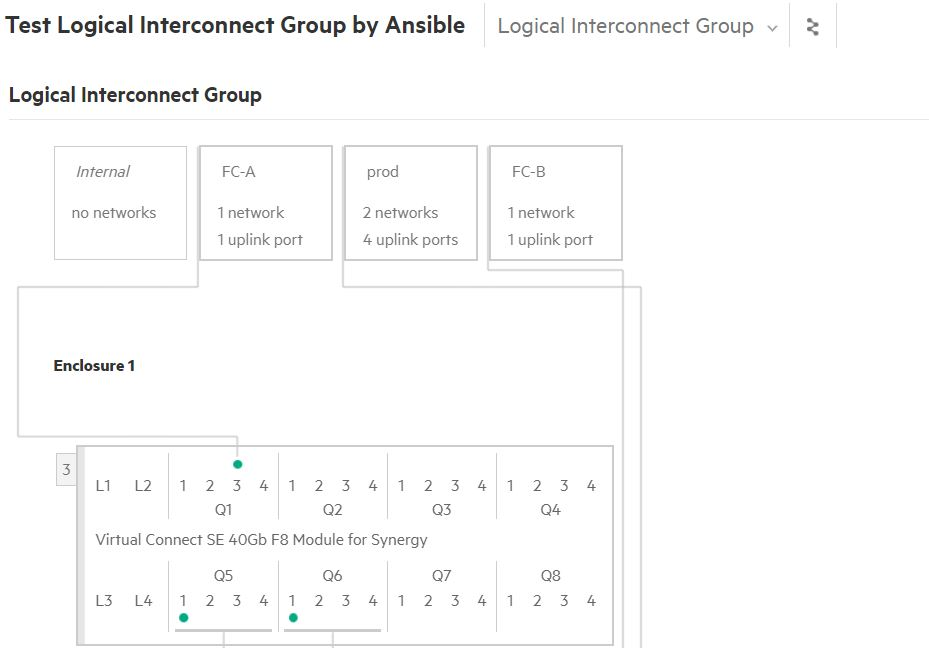

## Lege ein Storage Volume, vergrößere es und lege ein neues Storage Volume Template an

In [53]:
cat << 'EOF' >oneview_volume.yml
---
- hosts: all
  vars:
    config: '{{ playbook_dir }}/oneview_config.json'
    storage_pool_uri: '/rest/storage-pools/EA639793-DA28-450B-880E-AB0A00D2156A'   ##fc_r6
    storage_system_uri: '/rest/storage-systems/CZ38277F39'                         ##8220
  tasks:

    - name: Create a Volume with a specified Storage Pool
      oneview_volume:
        config: '{{ config }}'
        state: present
        data:
          properties:
            name: 'Volume created by Ansible through OneView'
            description: 'Test volume with common creation: Storage Pool'
            size: 2147483648  # 2GB
            storagePool: '{{ storage_pool_uri }}'
          templateUri: '/rest/storage-volume-templates/e77d91fd-c4de-4c3a-b952-ab0a00d21573'  ##Cluster Storage Template 500GB
          isPermanent: false
      delegate_to: localhost

#          initialScopeUris: ['/rest/scopes/754e0dce-3cbd-4188-8923-edf86f068bf7'] # This option available only with API version 600 and above

    - name: Extend the Volume size
      oneview_volume:
        config: '{{ config }}'
        state: present
        data:
          name: 'Volume created by Ansible through OneView'
          provisionedCapacity: 2684354560  # 2.5GB - The volume actual size
      delegate_to: localhost

EOF
ansible-playbook -i hosts oneview_volume.yml


PLAY [all] *********************************************************************

TASK [Create a Volume with a specified Storage Pool] ***************************
changed: [10.0.20.50 -> localhost]

TASK [Extend the Volume size] **************************************************
changed: [10.0.20.50 -> localhost]

PLAY RECAP *********************************************************************
10.0.20.50                 : ok=2    changed=2    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   



In [ ]:
cat << 'EOF' >oneview_volume_tp.yml

- hosts: all
  vars:
    config: "{{ playbook_dir }}/oneview_config.json"

    storage_pool_uri: '/rest/storage-pools/EA639793-DA28-450B-880E-AB0A00D2156A'   ##fc_r6

    storage_vol_templ_name: "Volume Template by Ansible"
    root_template_uri: "/rest/storage-volume-templates/e77d91fd-c4de-4c3a-b952-ab0a00d21573"
    svt_root_uri: "{{ root_template_uri }}"

  tasks:
    - name: Retrieve the Root Storage Volume Template
      oneview_storage_volume_template_facts:
        config: "{{ config }}"
        params:
          start: 0
          count: 1
          sort: 'name:descending'
          filter: isRoot='True'
      delegate_to: localhost


    - name: Create a Storage Volume Template
      oneview_storage_volume_template:
        config: "{{ config }}"
        state: present
        data:
          name: "{{ storage_vol_templ_name }}"
          rootTemplateUri: "{{ svt_root_uri }}"
          properties:
            name:
              meta:
                locked: false
              type: string
              title: Volume name
              required: true
              maxLength: 100
              minLength: 1
              description: A volume name between 1 and 100 characters
            size:
              meta:
                locked: false
                semanticType: capacity
              type: integer
              title: Capacity
              default: 1073741824
              maximum: 17592186044416
              minimum: 268435456
              required: true
              description: The capacity of the volume in bytes
            description:
              meta:
                locked: false
              type: string
              title: Description
              default: ''
              maxLength: 2000
              minLength: 0
              description: A description for the volume
            isShareable:
              meta:
                locked: false
              type: boolean
              title: Is Shareable
              default: false
              description: The shareability of the volume
            storagePool:
              meta:
                locked: false
                createOnly: true
                semanticType: device-storage-pool
              type: string
              title: Storage Pool
              format: x-uri-reference
              required: true
              description: A common provisioning group URI reference
              default: "{{ storage_pool_uri }}"
            snapshotPool:
              meta:
                locked: true
                semanticType: device-snapshot-storage-pool
              type: string
              title: Snapshot Pool
              format: x-uri-reference
              default: "{{ storage_pool_uri }}"
              description: A URI reference to the common provisioning group used to create snapshots
            provisioningType:
              enum:
              - Thin
              - Full
              - Thin Deduplication
              meta:
                locked: true
                createOnly: true
              type: string
              title: Provisioning Type
              default: Full
              description: The provisioning type for the volume
          description: ''
      delegate_to: localhost
EOF
ansible-playbook -i hosts oneview_volume_tp.yml

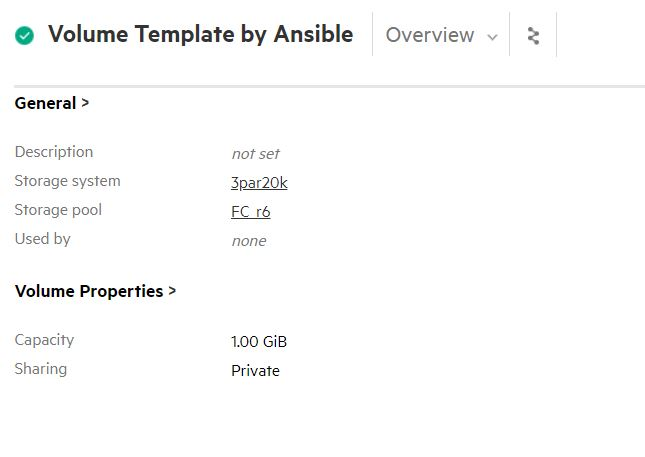

## Anzeige aller logical JBODs

In [54]:
cat << 'EOF' >oneview_ljbod.yml

- hosts: all
  vars:
    config: "{{ playbook_dir }}/oneview_config.json"

  tasks:
     - name: Gather facts about a SAS Logical JBOD by name, with the list of drives allocated
       oneview_sas_logical_jbod_facts:
          config: "{{ config }}"
          options:
            - drives
       delegate_to: localhost

     - debug: var=sas_logical_jbods
     #- debug: var=sas_logical_jbod_drives
     - debug: msg="{{sas_logical_jbods | map(attribute='name') | list }}"
     

EOF
ansible-playbook -i hosts oneview_ljbod.yml


PLAY [all] *********************************************************************

TASK [Gather facts about a SAS Logical JBOD by name, with the list of drives allocated] ***
ok: [10.0.20.50 -> localhost]

TASK [debug] *******************************************************************
ok: [10.0.20.50] => {
    "sas_logical_jbods": [
        {
            "category": "sas-logical-jbods",
            "clearMetaData": false,
            "created": "2019-11-25T08:24:26.608Z",
            "description": null,
            "driveTechnology": {
                "deviceInterface": "SATA",
                "driveMedia": "SSD"
            },
            "eTag": "2019-11-25T08:24:26.608Z",
            "eraseData": true,
            "logicalDriveBayUris": [
                "/rest/sas-logical-interconnects/05a7e773-2b24-4598-b70a-bb922d9bce39/logical-drive-enclosures/a1d5ee38-366c-40c1-8dbb-b3c513dc62e4/logical-drive-bays/a8f7a177-72ff-4a76-b561-75de7c0e49f8",
                "/rest/sas-logical-inter

# Abfolge: Deployment eines Servers und Konfiguration: 
Deploye einen neuen Host (create SP from SP Template), ermittle die IP des Hosts (linux_gatherSP) und konfiguriere einen Webserver auf diesem Host (linux_start_nginx)
HE11, Bay10 wird verwendet, wenn nicht frei nutze ein anderes Blade vom Type:  SY 480 Gen9 M1:542SA M3:3820CNA

## Anlegen eines SP anahand eines SPT mit Deployment, Power On des Blades

In [ ]:
cat << 'EOF' > oneview_newSP_from_SPT.yml

- hosts: localhost
  vars:
    config: "oneview_config.json"
    api_version: 1000
  tasks:
     - name: Create server profile SP-from template
       oneview_server_profile:
         config: "{{ config }}"
         state: present
         data:
             name:                       "Docker Host for WebServer"
             description:                "Assigned by Ansible Playbook"
             serverHardwareName:         "CTC H5 HE11, bay 1"
             serverProfileTemplateName:  "CTC_RHEL7_Docker_SPT"
             osDeploymentSettings:
               osDeploymentPlanName: "CTC-RHEL77-EFI-teaming"
               osCustomAttributes:
               -  name: DomainName
                  value: demo.local
               -  name: NewRootPassword
                  value: <XXX>
               -  name: NewUser
                  value: demouser
               -  name: NewUsersPassword
                  value: demouserPassword
               -  name: HostName
                  value: runderTable
               -  name: NICTeam0Name
                  value:  MGMT1
               -  name: SSH
                  value: Enable
               -  name: TotalNICTeamings
                  value: 1
               -  name: NICTeam1Name
                  value:  MGMT2
               -  name: Team0NIC1.connectionid
                  value: 3
               -  name: Team0NIC1.networkuri
                  value: /rest/ethernet-networks/d6b3e24a-c948-4d76-93d8-c7855bce4c81
               -  name: Team0NIC1.constraint
                  value: auto
               -  name: Team0NIC2.connectionid
                  value: 4
               -  name: Team0NIC2.networkuri
                  value: /rest/ethernet-networks/d6b3e24a-c948-4d76-93d8-c7855bce4c81
               -  name: Team0NIC2.constraint
                  value: auto
       delegate_to: localhost

     - name: Power On the server hardware
       oneview_server_hardware:
        config: "{{ config }}"
        state: power_state_set
        data:
            name: "CTC H5 HE11, bay 1"
            powerStateData:
                powerState: "On"
                powerControl: "MomentaryPress"
       delegate_to: localhost
EOF

In [ ]:
ansible-playbook -i hosts oneview_newSP_from_SPT.yml ## dauert ca 2 Minuten für das erzeugen des SP und dann kommt der boot des Servers

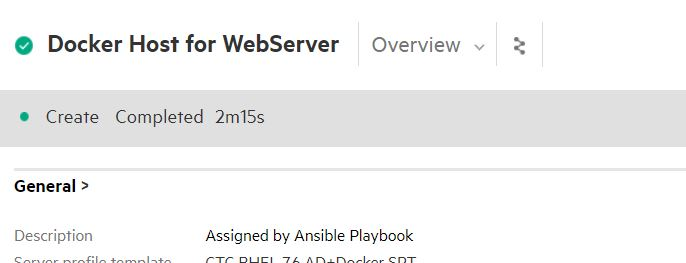

## IP Adresse ermitteln und neues inventory File anlegen

In [ ]:
cat << 'EOF' >linux_gatherSP.yml
- hosts: localhost
  vars:
    - config: "{{ playbook_dir }}/oneview_config.json"
    - IPADDR: "not def"

  tasks:
    - name: Gather facts about a Server Profile by name
      oneview_server_profile_facts:
        config: "{{ config }}"
        name: "Docker Host for WebServer"
      delegate_to: localhost


#    - debug: var=server_profiles
#    - debug: msg="{{server_profiles[0].osDeploymentSettings.osCustomAttributes[15] }}"


    - name: IP Addresse ermitteln
      when: '"{{ item.name }}" == "Team0NIC1.ipaddress"'
      set_fact: IPADDR={{ item.value}}
      with_items: "{{ server_profiles[0].osDeploymentSettings.osCustomAttributes }}"

    - debug: msg='" {{ IPADDR }}"'


    - copy:
         dest: "{{ playbook_dir }}/inv.json"
         content: |
           {{ IPADDR }}  ansible_connection=ssh ansible_user=root ansible_ssh_pass=xxxx ansible_python_interpreter=/bin/python
EOF

In [ ]:
ansible-playbook -i hosts linux_gatherSP.yml

## nginx Container deployen, starten und konfigurieren

In [ ]:
cat << 'EOF' >linux_start_nginx.yml
- hosts: all
  tasks:
     - name: install some prereq 1/2
       copy: src={{ playbook_dir }}/prepLinux.sh dest=/root/prepLinux.sh mode=0777



     - name: start nginx on deployed server
       docker_container:
           image: nginx:latest
           name: nginx
           state: started
           published_ports: 80:80
EOF





In [ ]:
# ist der neue Server fertig mit booten?, dann...
ansible-playbook -i inv.json linux_start_nginx.yml

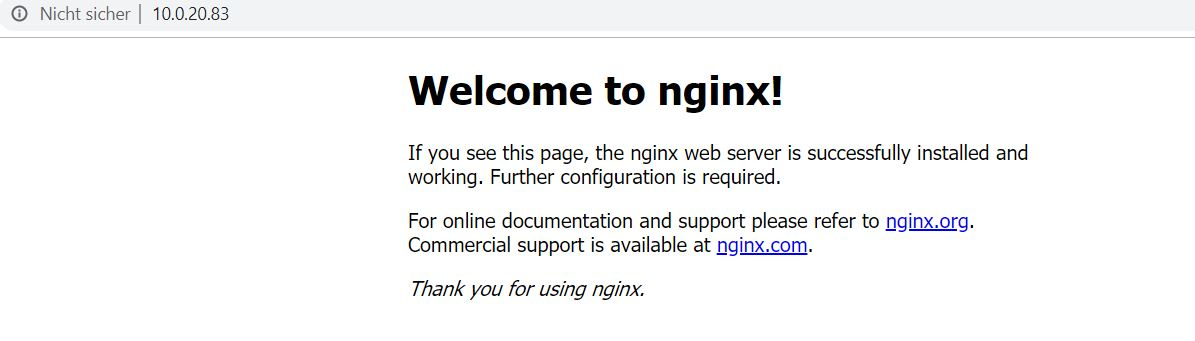

 ####cleanup

























cleanup
löschen: Netzwork: "AnsibleTestNetwork_*"
        Server_profile: "SP-created by Ansible", "Docker Host for WebServer",VCG19LW04X
        Volumes 'Volume created by Ansible through OneView' und Volume TP "Volume Template by Ansible"
        LIG: 'Test Logical Interconnect Group by Ansible'
        User: nobody

In [ ]:
cat << 'EOF' >oneview_cleanup_DEMO.yml
---
- hosts: all
  vars:
    config: "{{ playbook_dir }}/oneview_config.json"

  tasks:
    - name: Delete the Ethernet Network1
      oneview_ethernet_network:
        config: "{{ config }}"
        state: absent
        data:
          name: AnsibleTestNetwork_1
      delegate_to: localhost
      register: deleted
    - name: Delete the Ethernet Network2
      oneview_ethernet_network:
        config: "{{ config }}"
        state: absent
        data:
          name: AnsibleTestNetwork_2
      delegate_to: localhost
      register: deleted
    - name: Delete the Ethernet Network3
      oneview_ethernet_network:
        config: "{{ config }}"
        state: absent
        data:
          name: AnsibleTestNetwork_3
      delegate_to: localhost
      register: deleted
    - name: Delete the Ethernet Network5
      oneview_ethernet_network:
        config: "{{ config }}"
        state: absent
        data:
          name: AnsibleTestNetwork_5
      delegate_to: localhost
      register: deleted
    - name: Delete the Ethernet Network7
      oneview_ethernet_network:
        config: "{{ config }}"
        state: absent
        data:
          name: AnsibleTestNetwork_7
      delegate_to: localhost
      register: deleted

    - name: Delete the Server Profile "SP-created by Ansible"
      oneview_server_profile:
        config: "{{ config }}"
        state: "absent"
        data:
          name: "SP-created by Ansible"
      delegate_to: localhost
      register: deleted

    - name: Delete the Server Profile "VCG6LQ801P"
      oneview_server_profile:
        config: "{{ config }}"
        state: "absent"
        data:
          name: "VCG6LQ801P"
      delegate_to: localhost
      register: deleted

    - name: Power Off the server hardware HE11bay10
      oneview_server_hardware:
        config: "{{ config }}"
        state: power_state_set
        data:
            name: "CTC H5 HE11, bay 1"
            powerStateData:
                powerState: "Off"
                powerControl: "PressAndHold"
      delegate_to: localhost
      register: register

    - name: Delete the Server Profile
      oneview_server_profile:
         config: "{{ config }}"
         state: "absent"
         data:
           name: "Docker Host for WebServer"
      delegate_to: localhost
      register: deleted

    - name: Delete the volume previously created
      oneview_volume:
        config: '{{ config }}'
        state: absent
        data:
          name: 'Volume created by Ansible through OneView'
      delegate_to: localhost
    - name: Delete the Storage Volume Template
      oneview_storage_volume_template:
        config: "{{ config }}"
        state: absent
        data:
            name: "Volume Template by Ansible"
      delegate_to: localhost
      register: deleted

    - name: Delete the Logical Interconnect Group
      oneview_logical_interconnect_group:
        config: "{{ config }}"
        state: absent
        data:
          name: 'Test Logical Interconnect Group by Ansible'
      delegate_to: localhost
      register: deleted
      
    - name: Delete a User
      oneview_user:
        config: "{{ config }}"
        data:
          name: "nobody"
        state: absent
      delegate_to: localhost
      register: deleted


EOF

In [ ]:
ansible-playbook -i hosts oneview_cleanup_DEMO.yml

# Ansible Deployment via iLO

In [ ]:
##for reference only
##
# Copyright 2017 Hewlett Packard Enterprise Development LP
#
# Licensed under the Apache License, Version 2.0 (the "License");
# You may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#
# Brought to you by the fine Folks at the America's Solution Center located in Beautiful Alpharetta GA...
# Error free since 9 AM this morning!!!!
###

- hosts: localhost
  gather_facts: no
  vars:
    config: '{{ playbook_dir }}/oneview_config.json'
    server_hardware_type_name: " SY480G10 M1:416SA M3:4820CNA"
    enclosure_group_name: "3 Frame VC-ETH SAS-Switch"
    auto_assign_server_hardware: "False"
    ov_server:         "CTC H5 HE21, bay 3"
    ovpythonPW: !vault |
          $ANSIBLE_VAULT;1.1;AES256
          62623963656162326433363139363133653630393739356564343536323839326165396162383832
          3538333332396132383336623163396439303064313263330a326231646338316138393933313036
          31353965393039656661303661306561613633626539313030636538366532646233386333346130
          6239343739353364310a353636323539623863333632353063386538306565376234383736383532
          3062
    iloPW: !vault |
          $ANSIBLE_VAULT;1.1;AES256
          63386562623766626664663564643539663638393830373539326531383364313530623432623830
          3037613863633365613132356338333336323733376665640a373436636530303165643532393632
          63643864353733346538663038376630353465303930316434373762613261366561323930353066
          3434643164646439360a343363616335623062616331643136616439326134343334366138633838
          6330
    vcenterPW: !vault |
          $ANSIBLE_VAULT;1.1;AES256
          38353061353361326238643663306531383634333838303339386137663630653065656439643831
          3665393730363038313362633765396161373139396233660a663664323963306361383261323664
          36386461633935373266393434653434306162656633636264663964333966373863383232333666
          6337313530626238610a646562663463343136393363313866373163353538633165323161653231
          6639

  vars_prompt:

    - name: osflavor
      prompt: "Please select the OS to Install.\n1- OS_ESXI\n2- OS_RHEL\n3- OS_CentOS with Docker \n"
      private: no

    - name: profile_name
      prompt: "Please enter a name for the Server Profile.\n"
      private: no

    - name: ipaddr
      prompt: "Please enter the server IP address.\n"
      private: no

    - name: hostn
      prompt: "Please enter  the Server Hostname.\n"
      private: no

  tasks:
    - set_fact: osflavor=ESXIBOOT osbase=ESXIBASE ov_template=ANSIBLE_OS_Deploy_via_iLO install=http://osdepl.demo.local/esx67/esx67u3custom.iso source=ksesx.cfg.j2 destination=/persistent/osdepl/esx67/ks_custom67.cfg
      when: (osflavor == "1")

    - set_fact: osflavor=LINUXBOOT2 osbase=LINUXBOOT ov_template=ANSIBLE_OS_Deploy_via_iLO install=http://osdepl.demo.local/rhel77/rhel77custom.iso source=ksrhel.cfg.k2 destination=/persistent/osdepl/rhel77/rhel77ks.cfg
      when: (osflavor == "2")

    - set_fact: osflavor=LINUXBOOT3 osbase=LINUXBOOT ov_template=ANSIBLE_OS_Deploy_via_iLO install=http://osdepl.demo.local/centos/centos7custom.iso source=kscentos.cfg.k2 destination=/persistent/osdepl/centos/centos7ks.cfg
      when: (osflavor == "3")


    - debug: var=ipaddr
    - debug: var=osbase
    - debug: var=hostn

    - name: create custom kickstart file
      template:
        src: "{{source}}"
        dest:  "{{destination}}"
      delegate_to: localhost

    - name: Get sessionID
      uri:
        url: https://10.0.20.50/rest/login-sessions
        validate_certs: no
        method: POST
        body_format: json
        headers:
           accept: "application/json"
           Content-Type: "application/json"
        body: {"userName":"python","password":"{{ovpythonPW}}"}
        status_code: 200
        return_content: yes
      register: sessionid

    - name : Parsing sessionID
      debug:
        msg: "{{sessionid.json.sessionID}}"

    - name : "Create Server Profile from Template - {{ profile_name }}"
      oneview_server_profile:
        config: "{{ config }}"
        data:
          name: "{{ profile_name }}"
          serverProfileTemplateName: "{{ ov_template }}"
          serverHardwareName:         "{{ ov_server }}"
      register: mpHostInfo
      delegate_to: localhost
    - debug:
#        var: mpHostInfo
        var:  server_hardware.mpHostInfo.mpIpAddresses[1].address

    - name: Task to boot a system using an ISO from an HP iLO interface only if the system is an HP server
      hpilo_boot:
        host: "{{ server_hardware.mpHostInfo.mpIpAddresses[1].address }}"
        login: skoch
        password: "{{ iloPW }}"
        media: cdrom
        image: "{{ install }}"
      delegate_to: localhost
#    - debug: var=ansible_facts

# Waiting for the server boot to complete, test for Port 22
    - name: wait for port 22 to become active
      wait_for:
        host: "{{ipaddr}}"
        port: 22
        delay: 20
        state: started
        timeout: 1600
      delegate_to: localhost

#    - name: Remove file (delete file)
#      file:
#        path: "/var/www/html/build/{{destion}}"
#        state: absent
#      delegate_to: localhost



    - name: Install Nginx
      remote_user: vagrant
      become: yes
      become_method: sudo
      docker_container:
        name: nginx
        image: nginx:latest
        detach: True
        ports:
            - 80:80
      delegate_to: "{{ ipaddr }}"
      when: (osflavor == "LINUXBOOT3")


    - name: Tweak Nginx
      remote_user: vagrant
      become: yes
      become_method: sudo
      command:  docker exec -it nginx sed -i 's/nginx/Discover More/g' /usr/share/nginx/html/index.html
      delegate_to: "{{ ipaddr }}"
      when: (osflavor == "LINUXBOOT3")



    - name: Add ESXi Host to vCenter
      vmware_host:
        hostname: 'suo04ctcvcsa001.demo.local'
        username: 'skoch@vsphere.local'
        password: '{{ vcenterPW }}'
        datacenter_name: Demodatacenter
        cluster_name: Democluster
        esxi_hostname: '{{ ipaddr }}'
        esxi_username: 'root'
        esxi_password: 'HP1nvent!'
        state: present
        validate_certs: False
      delegate_to: localhost
      when: (osflavor == "ESXIBOOT")


# Ansible "for 3PAR/Primera"

In [ ]:
 pip3 install hpe3par-sdk --user notebook --no-cache-dir


In [ ]:
cat <<'EOF' >cred.yml
    storage_system_username: kochstep
    storage_system_password: <PW>
EOF
chmod 444 cred.yml

In [ ]:
cat cred.yml

In [24]:

cat << 'EOF' >3par_vol1.yml
- hosts: localhost
  gather_facts: no
  vars:
    storage_system_ip: 10.0.40.50
    volume_name: "TESTSK"
    cpg: FC_r6
  vars_files:
    - cred.yml
    
    
  tasks:
    - name: Create Volume "{{ volume_name }}"
      hpe3par_volume: 
        storage_system_ip="{{ storage_system_ip }}"
        storage_system_username="{{ storage_system_username }}"
        storage_system_password="{{ storage_system_password }}"
        state=present 
        volume_name="{{ volume_name }}"
        cpg="{{ cpg }}"
        size="2048"
        snap_cpg="FC_r1"
        state=present                    #present, absent, grow
EOF
ansible-playbook 3par_vol1.yml

[WARNING]: No inventory was parsed, only implicit localhost is available
[WARNING]: provided hosts list is empty, only localhost is available. Note that
the implicit localhost does not match 'all'

PLAY [localhost] ***************************************************************

TASK [Create Volume "TESTSK"] **************************************************
changed: [localhost]

PLAY RECAP *********************************************************************
localhost                  : ok=1    changed=1    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   



In [23]:
cat << 'EOF' >3par_vol_snap.yml
- hosts: localhost
  gather_facts: no
  vars:
    storage_system_ip: 10.0.40.50
    volume_name: "TESTSK"
    cpg: FC_r6
  vars_files:
    - cred.yml

  tasks:
    - name: Create Volume snasphot my_ansible_snapshot
      hpe3par_snapshot: 
        storage_system_ip="{{ storage_system_ip }}"
        storage_system_username="{{ storage_system_username }}"
        storage_system_password="{{ storage_system_password }}"
        state=present
        snapshot_name="{{volume_name}}-snapshot1"
        base_volume_name="{{volume_name}}"
        read_only=False
        state=present
EOF
        
ansible-playbook 3par_vol_snap.yml

[WARNING]: No inventory was parsed, only implicit localhost is available
[WARNING]: provided hosts list is empty, only localhost is available. Note that
the implicit localhost does not match 'all'

PLAY [localhost] ***************************************************************

TASK [Create Volume snasphot my_ansible_snapshot] ******************************
changed: [localhost]

PLAY RECAP *********************************************************************
localhost                  : ok=1    changed=1    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   



In [61]:
#/home/user/workspace/hpe3par_ansible/Modules
ansible-playbook --version

ansible-playbook 2.9.4
  config file = /home/notebook/notebooks/ansible.cfg
  configured module search path = ['/home/notebook/hponeview/oneview-ansible/library']
  ansible python module location = /usr/local/lib/python3.7/site-packages/ansible
  executable location = /usr/local/bin/ansible-playbook
  python version = 3.7.5 (default, Oct 17 2019, 12:21:00) [GCC 8.3.1 20190223 (Red Hat 8.3.1-2)]


# Vmware: Snapshot ALL VMs of vcenter

In [ ]:
    
- hosts: localhost
  gather_facts: no
  vars:
    vcenter_hostname: vc.container.demo.local
    vcenter_username: skoch@demo.local
    vcenter_password: "<PW>"
    datacenter_name: ctcbbn
#    time: "{{ lookup('pipe', 'date -d \"0 day ago\" +\"%Y%m%d\"') }}"
    time: "{{ lookup('pipe', 'date +%d\') }}"




  tasks:
    - name: Gather all registered virtual machines
      vmware_vm_info:
        hostname: '{{ vcenter_hostname }}'
        username: '{{ vcenter_username }}'
        password: '{{ vcenter_password }}'
        vm_type: vm
        validate_certs: False
      delegate_to: localhost
      register: vminfo

#    - debug: msg="{{ item.guest_name }}"
#      with_items: "{{ vminfo.virtual_machines }}"

    - name: Remove a snapshot before creating an new
      vmware_guest_snapshot:
        hostname: "{{ vcenter_hostname }}"
        username: "{{ vcenter_username }}"
        password: "{{ vcenter_password }}"
        datacenter: "{{ datacenter_name }}"
        folder: "/{{ datacenter_name }}/vm/"
        name: "{{ item.guest_name }}"
        state: absent
        snapshot_name: snap1-{{ time }}
        validate_certs: False
      delegate_to: localhost
      with_items: "{{ vminfo.virtual_machines }}"

    - name: Create a snapshot
      vmware_guest_snapshot:
        hostname: "{{ vcenter_hostname }}"
        username: "{{ vcenter_username }}"
        password: "{{ vcenter_password }}"
        datacenter: "{{ datacenter_name }}"
        folder: "/{{ datacenter_name }}/vm/"
        name: "{{ item.guest_name }}"
        state: present
        snapshot_name: snap1-{{ time }}
        description: snap1_description
        validate_certs: False
      delegate_to: localhost
      with_items: "{{ vminfo.virtual_machines }}"
